In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
sys.path.append(os.path.abspath(".."))

from datasets.xor import XOR
from experiment.runExperiment import RunExperiment
from experiment.models import ModelSetups
from training.train import TrainUtil
from metrics.charts import ChartUtil
from models.enums.chartType import TrainingCharts
import torch
from metrics.accuracy import get_accuracy
from metrics.modelAnalysisUtils import ModelAnalysisUtils
from models.modelAnalysis.multiRunAnalysis import MultiRunAnalysis
from matplotlib import pyplot as plt
import seaborn as sns
from models.enums.similarityType import AbsSimilarityType
import numpy as np
import torch.nn as nn

In [3]:
def combine_charts(chartUtils: dict[str, ChartUtil]):
    model_keys = list(chartUtils.keys())
    combined_charts: ChartUtil = chartUtils[model_keys[0]]

    for key in model_keys[1:]:
        combined_charts = combined_charts.combine_charts(chartUtils[key])

    combined_charts.set_colors_map()
    return combined_charts

In [4]:
dataset = XOR()
in_features = 2
out_features = 2
X_train, y_train, X_val, y_val = dataset.get_dataset(in_features = in_features, unique=False)
trainUtil = TrainUtil(X_train, y_train, X_val = X_val, y_val = y_val)

In [6]:
layers = 3
model_params_base = {"l1": (200, 10), "l2": (200, 10), "l3": (200, 10)}

In [7]:
experiment = RunExperiment(trainUtil)
modelSetups = ModelSetups()
trainUtil.set_data_granularity(1)

In [17]:
lr = 0.01
chartUtils_3l_relu = {}
chartUtils_3l_relu["Dense model"] = experiment.perform_one_experiment(
        models = {
            "Dense Model": modelSetups._get_dense_model,
            },
        in_features = in_features, 
        out_features = out_features, 
        layers = layers, 
        model_params = model_params_base,
        n_epochs = 100,
        n_runs=10,
        batch_train= True,
        seed = 0,
        random_sequencing=True,
        activation = nn.Sigmoid(),
        lr = lr
        )
chartUtils_3l_relu["Complete Sparse model"] = experiment.perform_one_experiment(
    models = {
        "Complete Sparse Model": modelSetups._get_sparse_model,
        },
    in_features = in_features, 
    out_features = out_features, 
    layers = layers, 
    model_params = model_params_base,
    n_epochs = 100,
    n_runs=10,
    batch_train= True,
    seed = 0,
    random_sequencing=True,
    activation = nn.Sigmoid(),
    lr = lr
    )

In [18]:
combined_charts_3l_relu = combine_charts(chartUtils_3l_relu)

/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_5957/1127750225.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = plt.cm.get_cmap('tab20', len(models))


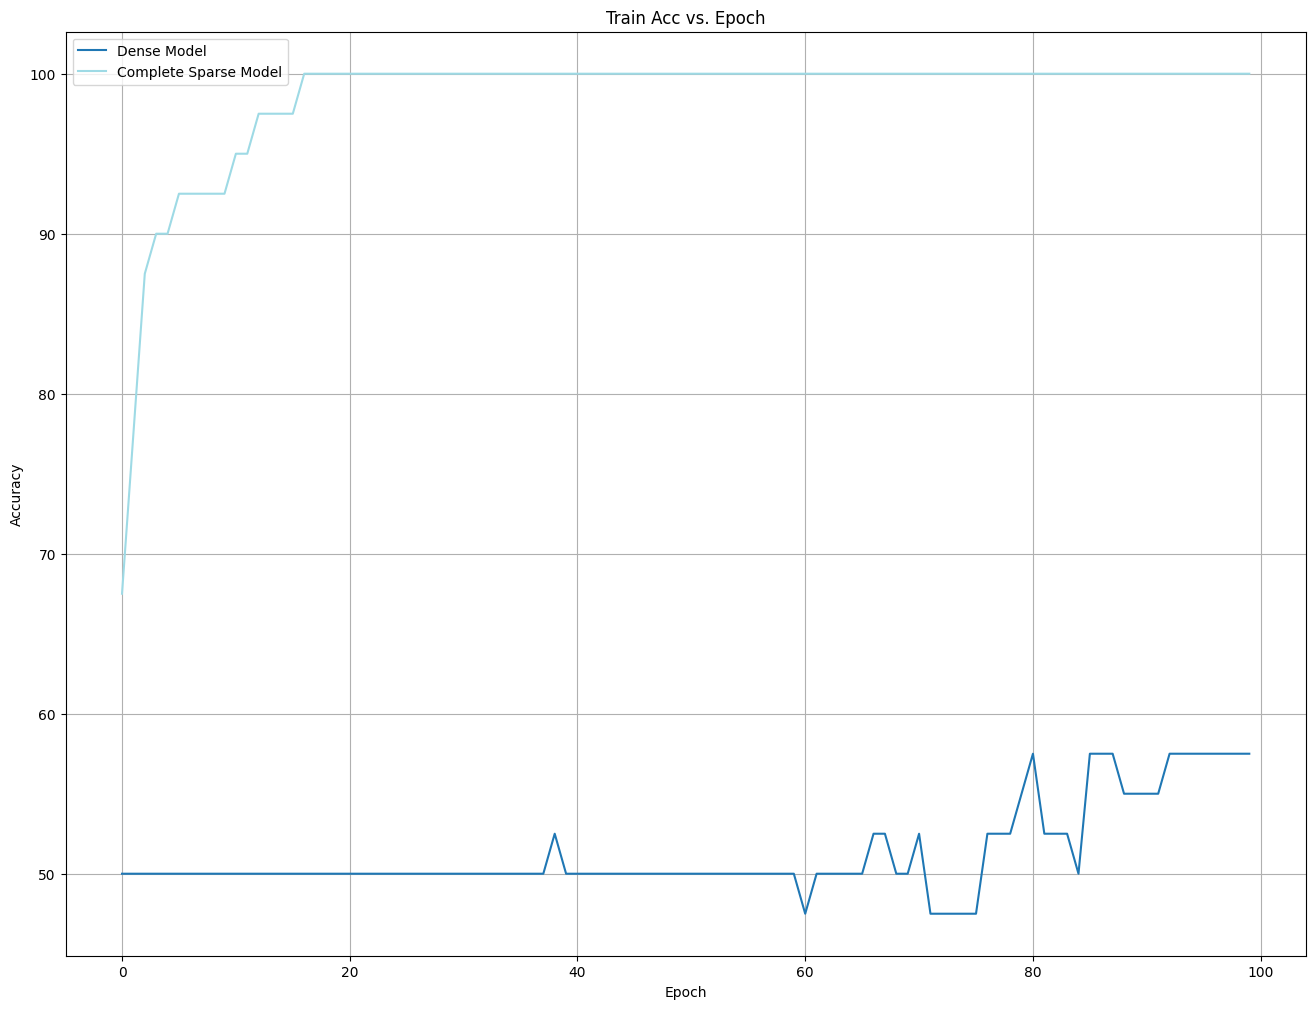

In [19]:
# plt.style.use('seaborn-v0_8')

fig, ax = plt.subplots(figsize=(16, 12))

models = list(combined_charts_3l_relu.results.train_data.keys())
viridis = plt.cm.get_cmap('tab20', len(models))
color_idx = 0
for modelName, model_data in combined_charts_3l_relu.results.train_data.items():
    epochs = model_data.get_epoch_numbers()

    mean_acc = []
    ci_acc = []
    epochs = list(model_data.epochs.keys())
    for epoch in model_data.epochs:
        epoch_data = model_data.epochs[epoch]
        
        mean, ci = epoch_data.get_value_mean_std_by_type(TrainingCharts.TRAIN_ACC, needCI=True)
        mean_acc.append(mean)
        ci_acc.append(ci)

    mean_acc = np.array(mean_acc)
    ci_acc   = np.array(ci_acc)

    color = viridis(color_idx)
    color_idx += 1

    ax.plot(epochs, mean_acc, label=f"{modelName}", color = color)

    # Plot shaded region for 95% confidence interval
    # ax.fill_between(
    #     epochs,
    #     mean_acc - ci_acc,
    #     mean_acc + ci_acc,
    #     alpha=0.25,
    #     color=color
    # )

# Add labels, legend, etc.
ax.set_title(f"Train Acc vs. Epoch")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.legend()
ax.grid(True)

In [60]:
def get_models(experiment = experiment, needTrainActivations = False, lr = 0.01):
    sparseResults, trainActivations, testActivations = experiment.train_models(
        models = {
            "Dense Model": modelSetups._get_dense_model,
            },
        in_features = in_features, 
        out_features = out_features, 
        layers = layers, 
        model_params = model_params_base,
        n_epochs = 100,
        batch_train= False,
        seed = 0,
        random_sequencing=True,
        activation = nn.ReLU(),
        return_train_acts = needTrainActivations,
        lr = lr
    )

    newSparseResults, newTrainActivations, newTestActivations = experiment.train_models(
            models = {
            "Complete Sparse Model": modelSetups._get_sparse_model,
            },
            in_features = in_features, 
            out_features = out_features, 
            layers = layers, 
            model_params = model_params_base,
            n_epochs = 100,
            batch_train= False,
            seed = 0,
            random_sequencing=True,
            activation = nn.ReLU(),
            return_train_acts = needTrainActivations,
            lr = lr
        )
    sparseResults = sparseResults | newSparseResults
    trainActivations = trainActivations | newTrainActivations
    testActivations = testActivations | newTestActivations
    return sparseResults, trainActivations, testActivations

In [61]:
multi_run_analysis = MultiRunAnalysis()
modelAnalysisUtils = ModelAnalysisUtils()

In [62]:
n_runs = 1
for i in range(n_runs):
    sparseResults, trainActivations, testActivations = get_models(needTrainActivations=True)
    sparseActivations = {}
    with torch.no_grad():
        for modelName, model in sparseResults.items():
            op, sparseActivations[modelName] = model.forward(X_val, return_acts = True)
            accuracy = get_accuracy(model, X_val, y_val)
            if accuracy != 1.:
                print(i, modelName, accuracy)
    multi_run_analysis.add_run_test_data(sparseActivations)

0 Dense Model 0.5
0 Complete Sparse Model 0.5


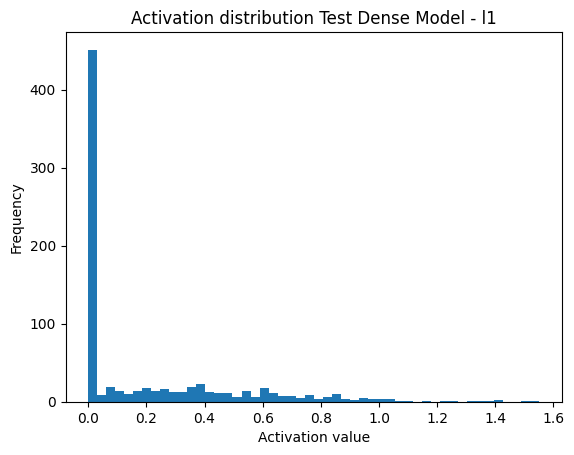

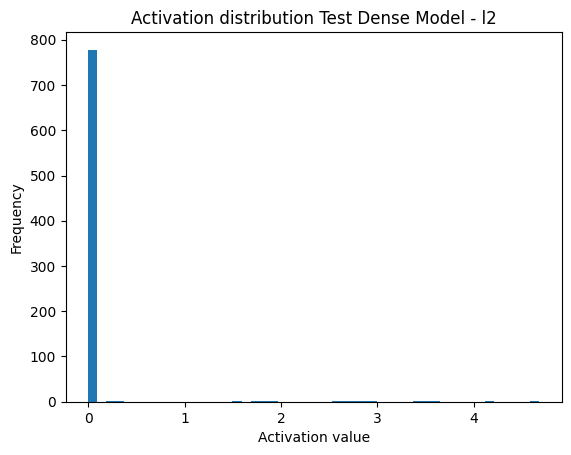

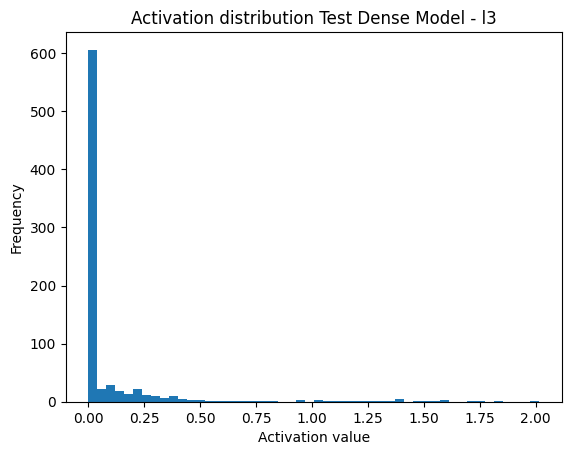

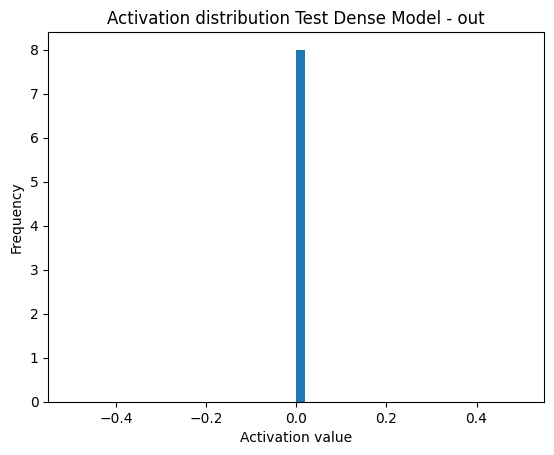

In [63]:
import numpy as np


run_number = 0
epoch_number = 149
layer_acts = {}
threshold = 1e-4
modelName = 'Dense Model'

for layerName, layerAnalysis in multi_run_analysis.models[modelName].test_analysis.items():
    acts = layerAnalysis.activation_values[run_number]
    flat = acts.flatten()
    # filtered_flat = flat[np.abs(flat) > threshold]
    plt.hist(flat, bins=50)
    plt.title(f'Activation distribution Test {modelName} - {layerName}')
    plt.xlabel('Activation value')
    plt.ylabel('Frequency')
    plt.show()